# Analyzer

Statistically, visually, and through machine learning compare mRNA and lncRNA sequences from GENCODE v38.

Assume the user downloaded files from GENCODE v38 [FTP](http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/)
to a subdirectory called data.

In [1]:
import time 
def show_time():
    t = time.time()
    s = time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))
    print(s)
show_time()

2021-07-30 19:14:24 UTC


## Import Dependencies


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import gzip
from scipy.stats import chisquare, kstest
import sys

from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
      f.write(s.text)  # writes to cloud local, delete the file later?
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/GenCodeTools.py')
    with open ('GenCodeTools.py', 'w') as f:
      f.write(s.text)
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/plot_generator.py')
    with open('plot_generator.py', 'w') as f:
      f.write(s.text)
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
      f.write(s.text)  
    from KmerTools import KmerTools
    from RNA_describe import *
    from GenCodeTools import *
    from plot_generator import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='../data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_describe import *
    from SimTools.GenCodeTools import *
    from SimTools.plot_generator import *
    from SimTools.KmerTools import KmerTools

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_describe():
    print("ERROR: Cannot use RNA_describe.")

On Google CoLab, mount cloud-local file, get our code from GitHub.
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Load GENCODE Data
Loads GENCODE v38 data.

Filters out mRNA sequences based on UTR check.

In [3]:
PC_FILENAME='gencode.v38.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v38.lncRNA_transcripts.fa.gz'
PC_FULLPATH=DATAPATH+PC_FILENAME
NC_FULLPATH=DATAPATH+NC_FILENAME
loader=GenCodeLoader()
loader.set_label(1)
loader.set_check_list(None) 
loader.set_check_utr(True)
pcdf=loader.load_file(PC_FULLPATH)
print("PC seqs loaded:",len(pcdf))
loader.set_label(0)
loader.set_check_list(None)
loader.set_check_utr(False)
ncdf=loader.load_file(NC_FULLPATH)
print("NC seqs loaded:",len(ncdf))
show_time()

PC seqs loaded: 70825
NC seqs loaded: 48752
2021-07-30 19:14:33 UTC


## Process Sequences


Generate Sample of GENCODE Data Set

Apply Length Constraints

Validate Sequences

In [4]:
MINIMUM_SEQUENCE_LENGTH = 200   #Minimum exclusive length to filter out sequences by
MAXIMUM_SEQUENCE_LENGTH = 4000  #Maximum inclusive length to filter out sequences by
SAMPLE_SIZE = 10000             #How many pc sequences and nc sequences respectively
REPRODUCABILITY_SEED = 314159   #Use to reproduce random sampling

Shuffle

In [5]:
pcdf = pcdf.sample(frac=1, random_state=REPRODUCABILITY_SEED)
ncdf = ncdf.sample(frac=1, random_state=REPRODUCABILITY_SEED)
show_time()

2021-07-30 19:14:33 UTC


Apply Length Constraints

In [6]:
def subset_list_by_len_bounds(input_list, min_len, max_len):
  return list(filter(lambda x: len(x) > min_len and len(x) <= max_len, input_list))

In [7]:
pc_sequences = pcdf['sequence'].tolist()
nc_sequences = ncdf['sequence'].tolist()

pc_sequences = subset_list_by_len_bounds(pc_sequences, MINIMUM_SEQUENCE_LENGTH, MAXIMUM_SEQUENCE_LENGTH)
nc_sequences = subset_list_by_len_bounds(nc_sequences, MINIMUM_SEQUENCE_LENGTH, MAXIMUM_SEQUENCE_LENGTH)

print('PC seqs in length range','('+str(MINIMUM_SEQUENCE_LENGTH),'-',str(MAXIMUM_SEQUENCE_LENGTH)+'):', len(pc_sequences))
print('NC seqs in length range','('+str(MINIMUM_SEQUENCE_LENGTH),'-',str(MAXIMUM_SEQUENCE_LENGTH)+'):', len(nc_sequences))
show_time()

#Garbage collection
pcdf = None
ncdf = None

PC seqs in length range (200 - 4000): 55381
NC seqs in length range (200 - 4000): 46912
2021-07-30 19:14:33 UTC


Validate Sequences

In [8]:
def valid_sequence(seq):
    """
    Checks if the given sequences if valid.
    """
    for chr in seq:
        if chr != 'A' and chr != 'C' and chr != 'G' and chr != 'T':
            return False
    return True

def validate_sequences(sequences):
    """
    Validate the given list of sequences
    """
    i = 0
    while i < len(sequences):
        if valid_sequence(sequences[i]):
            i += 1
        else:
            sequences.remove(sequences[i])

validate_sequences(pc_sequences)
validate_sequences(nc_sequences)

print('Valid PC seqs:', len(pc_sequences))
print('Valid NC seqs:', len(nc_sequences))
show_time()

Valid PC seqs: 55381
Valid NC seqs: 46911
2021-07-30 19:14:49 UTC


Reduce sample size

In [9]:
pc_sequences = pc_sequences[:SAMPLE_SIZE]
nc_sequences = nc_sequences[:SAMPLE_SIZE]
show_time()

2021-07-30 19:14:49 UTC


## Set Up MLP

In [10]:
RATIO_TRAIN_TO_TEST = 0.90
INPUT_SHAPE = (None, 4**3 + 4**2 + 4**1)
MAX_K = 3
NEURONS = 16
DROP_RATE = 0.1
EPOCHS = 10
SPLITS = 5
FOLDS = 5

Define what is training data and what is testing data

In [11]:
NUM_PC = len(pc_sequences)
NUM_PC_TRAIN = int(NUM_PC * RATIO_TRAIN_TO_TEST)
NUM_NC = len(nc_sequences)
NUM_NC_TRAIN = int(NUM_NC * RATIO_TRAIN_TO_TEST)

pc_train = pc_sequences[:NUM_PC_TRAIN]
pc_test = pc_sequences[NUM_PC_TRAIN:]
nc_train = nc_sequences[:NUM_NC_TRAIN]
nc_test = nc_sequences[NUM_NC_TRAIN:]

print('PC TRAIN:', len(pc_train))
print('NC TRAIN', len(nc_train))
print('PC TEST:', len(pc_test))
print('NC TEST:', len(nc_test))
show_time()

#Garbage Collection
pc_sequences = None
nc_sequences = None

PC TRAIN: 9000
NC TRAIN 9000
PC TEST: 1000
NC TEST: 1000
2021-07-30 19:14:49 UTC


Prepare the Inputs and the Labels

In [12]:
def prepare_x_and_y(seqs1, seqs0):
    """
    From Miller's MLP_GenCode_1??.
    """
    len1=len(seqs1)
    len0=len(seqs0)
    total=len1+len0
    L1=np.ones(len1,dtype=np.int8)
    L0=np.zeros(len0,dtype=np.int8)
    S1 = np.asarray(seqs1)
    S0 = np.asarray(seqs0)
    all_labels = np.concatenate((L1,L0))
    all_seqs = np.concatenate((S1,S0))  
    for i in range(0,len0):
        all_labels[i*2] = L0[i]
        all_seqs[i*2] = S0[i]
        all_labels[i*2+1] = L1[i]
        all_seqs[i*2+1] = S1[i]
    return all_seqs,all_labels
Xseq, y = prepare_x_and_y(pc_train, nc_train)
show_time()

2021-07-30 19:14:50 UTC


In [13]:
def seqs_to_kmer_freqs(seqs, max_K):
    """
    From Miller's MLP_GenCode_1??.
    """
    tool = KmerTools()  # from SimTools
    collection = []
    for seq in seqs:
        counts = tool.make_dict_upto_K(max_K)
        # Last param should be True when using Harvester.
        counts = tool.update_count_one_K(counts, max_K, seq, True)
        # Given counts for K=3, Harvester fills in counts for K=1,2.
        counts = tool.harvest_counts_from_K(counts, max_K)
        fdict = tool.count_to_frequency(counts, max_K)
        freqs = list(fdict.values())
        collection.append(freqs)
    return np.asarray(collection)

Xfrq = seqs_to_kmer_freqs(Xseq, MAX_K)
show_time()

#Garbage Collection
Xseq = None

2021-07-30 19:15:05 UTC


## Make and Train MLP

In [14]:
def make_DNN():
    """
    From Miller's MLP_GenCode_1??.
    """
    dt=np.float32
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()

    dnn.add(Dense(NEURONS, activation="sigmoid", dtype=dt))  # relu doesn't work as well
    dnn.add(Dropout(DROP_RATE))

    dnn.add(Dense(NEURONS, activation="sigmoid", dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))

    dnn.add(Dense(1, activation="sigmoid", dtype=dt))  

    dnn.compile(optimizer='adam',    # adadelta doesn't work as well
        loss=BinaryCrossentropy(from_logits=False),
        metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE) 
    return dnn
model = make_DNN()
print(model.summary())
show_time()

make_DNN
input shape: (None, 84)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                1360      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,649
Trainable params: 1,649
Non-trainable params: 0
_________________________________________________________________
None
2021-07-30 19:15:05 UTC


In [15]:
def do_cross_validation(X,y):
    """
    From Miller's MLP_GenCode_1??.
    """
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    # When shuffle=True, the valid indices are a random subset.
    splitter = KFold(n_splits=SPLITS, shuffle=True) 
    model = None
    for train_index, valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                epochs=EPOCHS, 
                verbose=1,  # ascii art while learning
                callbacks=mycallbacks,   # called at end of each epoch
                validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()
    return model  # parameters at end of training

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/10
450/450 [==============================] - 16s 3ms/step - loss: 0.7166 - accuracy: 0.5138 - val_loss: 0.6913 - val_accuracy: 0.5486
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 2/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6928 - accuracy: 0.5249 - val_loss: 0.6873 - val_accuracy: 0.5797
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 3/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6876 - accuracy: 0.5426 - val_loss: 0.6790 - val_accuracy: 0.5997
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 4/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6784 - accuracy: 0.5766 - val_loss: 0.6628 - val_accuracy: 0.6353
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 5/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6614 - accuracy: 0.6168 - val_loss: 0.6469 - val_accuracy: 0.6317
Epoch 6/10
450/450 [==================

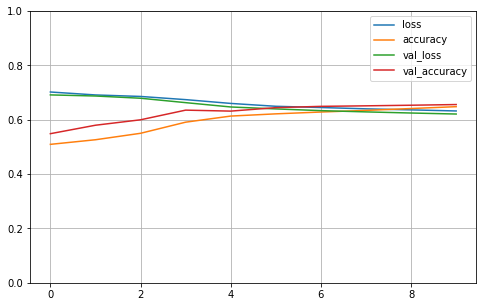

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/10
450/450 [==============================] - 2s 2ms/step - loss: 0.7003 - accuracy: 0.4911 - val_loss: 0.6898 - val_accuracy: 0.5892
Epoch 2/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6921 - accuracy: 0.5210 - val_loss: 0.6849 - val_accuracy: 0.5503
Epoch 3/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6848 - accuracy: 0.5574 - val_loss: 0.6720 - val_accuracy: 0.6350
Epoch 4/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6713 - accuracy: 0.5923 - val_loss: 0.6550 - val_accuracy: 0.6331
Epoch 5/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6587 - accuracy: 0.6085 - val_loss: 0.6447 - val_accuracy: 0.6314
Epoch 6/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6448 - accuracy: 0.6214 - val_loss: 0.6385 - val_accuracy: 0.6378
Epoch 7/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6416 - accuracy: 0.6328 - val

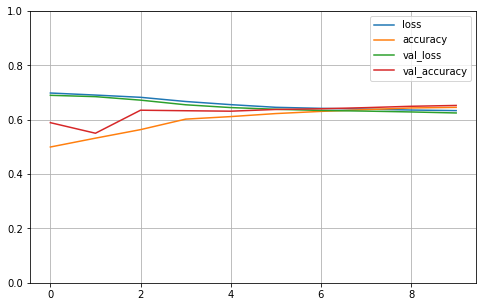

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/10
450/450 [==============================] - 2s 2ms/step - loss: 0.7191 - accuracy: 0.5051 - val_loss: 0.6901 - val_accuracy: 0.6450
Epoch 2/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6954 - accuracy: 0.5251 - val_loss: 0.6835 - val_accuracy: 0.6153
Epoch 3/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6885 - accuracy: 0.5404 - val_loss: 0.6713 - val_accuracy: 0.6386
Epoch 4/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6766 - accuracy: 0.5797 - val_loss: 0.6547 - val_accuracy: 0.6261
Epoch 5/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6628 - accuracy: 0.6024 - val_loss: 0.6404 - val_accuracy: 0.6439
Epoch 6/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6562 - accuracy: 0.6138 - val_loss: 0.6336 - val_accuracy: 0.6578
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 7/10
450/450 [==============================] -

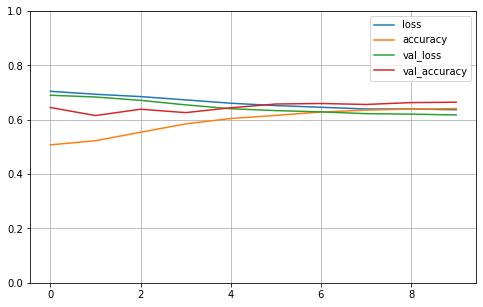

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/10
450/450 [==============================] - 2s 2ms/step - loss: 0.7082 - accuracy: 0.4980 - val_loss: 0.6905 - val_accuracy: 0.5108
Epoch 2/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6934 - accuracy: 0.5241 - val_loss: 0.6830 - val_accuracy: 0.6108
Epoch 3/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6869 - accuracy: 0.5456 - val_loss: 0.6702 - val_accuracy: 0.6222
Epoch 4/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6713 - accuracy: 0.5917 - val_loss: 0.6540 - val_accuracy: 0.6472
Epoch 5/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6579 - accuracy: 0.6160 - val_loss: 0.6451 - val_accuracy: 0.6486
Epoch 6/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6469 - accuracy: 0.6299 - val_loss: 0.6360 - val_accuracy: 0.6564
Epoch 7/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6402 - accuracy: 0.6312 - val

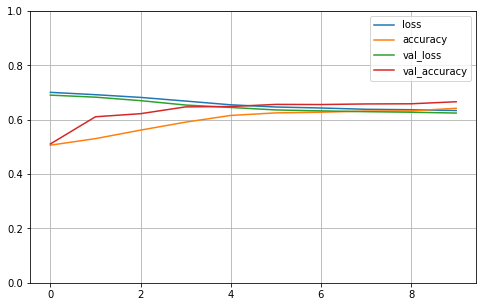

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/10
450/450 [==============================] - 2s 2ms/step - loss: 0.7517 - accuracy: 0.5041 - val_loss: 0.6926 - val_accuracy: 0.4975
Epoch 2/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6947 - accuracy: 0.5183 - val_loss: 0.6870 - val_accuracy: 0.6347
Epoch 3/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6887 - accuracy: 0.5440 - val_loss: 0.6791 - val_accuracy: 0.6064
Epoch 4/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6802 - accuracy: 0.5744 - val_loss: 0.6656 - val_accuracy: 0.6350
Epoch 5/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6656 - accuracy: 0.6000 - val_loss: 0.6483 - val_accuracy: 0.6222
Epoch 6/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6512 - accuracy: 0.6183 - val_loss: 0.6370 - val_accuracy: 0.6383
Epoch 7/10
450/450 [==============================] - 1s 2ms/step - loss: 0.6473 - accuracy: 0.6222 - val

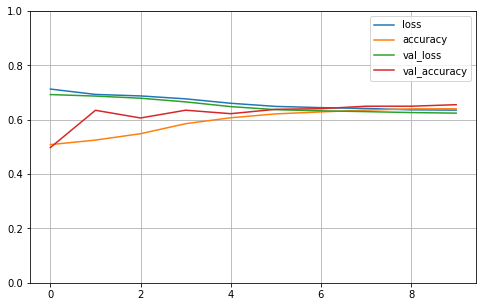

2021-07-30 19:16:23 UTC


In [16]:
best_model = do_cross_validation(Xfrq, y)
show_time()

## Show Results of MLP

In [17]:
def show_test_AUC(model, title, X, y):
    """
    From Miller's MLP_GenCode_1??.
    """
    ns_probs = [0 for _ in range(len(y))]
    bm_probs = model.predict(X)
    ns_auc = roc_auc_score(y, ns_probs)
    bm_auc = roc_auc_score(y, bm_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
    plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
    plt.title(title + ' ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print("%s: %.2f%%" %('AUC',bm_auc*100.0))
    
def show_test_accuracy(model,X,y):
    """
    From Miller's MLP_GenCode_1??.
    """
    scores = model.evaluate(X, y, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Accuracy on training data.
Prepare...
Extract K-mer features...
Plot...


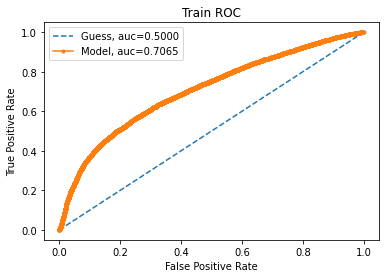

AUC: 70.65%
accuracy: 65.47%


In [18]:
print("Accuracy on training data.")
print("Prepare...")
X, y = prepare_x_and_y(pc_train, nc_train)
print("Extract K-mer features...")
X = seqs_to_kmer_freqs(X, MAX_K)
print("Plot...")
show_test_AUC(best_model, 'Train', X, y)
show_test_accuracy(best_model, X, y)

Accuracy on test data.
Prepare...
Extract K-mer features...
Plot...


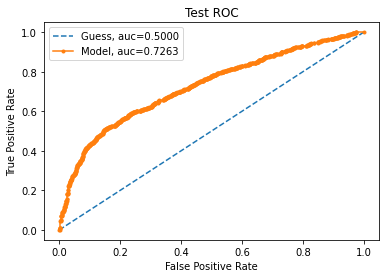

AUC: 72.63%
accuracy: 66.60%


In [19]:
print("Accuracy on test data.")
print("Prepare...")
X, y = prepare_x_and_y(pc_test, nc_test)
print("Extract K-mer features...")
X = seqs_to_kmer_freqs(X, MAX_K)
print("Plot...")
show_test_AUC(best_model, 'Test', X, y)
show_test_accuracy(best_model, X, y)